# PK_W281_EDA_&_Feature_Extraction_Cifar100.ipynb

  W281 Final Project 
  
  April 17, 2023  

  **Waqas Ali | Pedro Melendez | Prakash Krishnan**


This notebook performs basic EDA and assesses different feature extraction of the images in the CIFAR-100 data set. This notebook complements the individual model notebooks that builds different classifier models based on the feature extraction techniques illustrated here.

The following feature extraction techniques are demonstrated in this notebook.

1. **Histogram of Gradients (HOG)**
2. **Scale-Invariant Feature Transform (SIFT)**
3. **Gray level co-occurrence matrices (GLCM)**
4. **Harris Corner Detection**

Dataset Summary

This dataset has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs). 

Data Fields

    image: 32 by 32 RGB image 
    fine label: an integer code specifying the fine label class
    coarse label: mapping of a fine label to a coarse or super-class

Coarse Labels and Class

    0 aquatic_mammals, 1 fish, 2 flowers, 3 food_containers, 4 fruit_and_vegetables
    5 household_electrical_devices, 6 household_furniture, 7 insects
    8 large_carnivores, 9 large_man-made_outdoor_things, 
    10 large_natural_outdoor_scenes, 11 large_omnivores_and_herbivores
    12 medium_mammals, 13 non-insect_invertebrates, 14 people, 15 reptiles
    16 small_mammals, 17 trees, 18 vehicles_1, 19 vehicles_2

Fine Label to Coarse Label Mapping

    mapping = {
    'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
    'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
    'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
    'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
    'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
    'household electrical device': ['clock', 'computer_keyboard', 'lamp', 'telephone', 'television'],
    'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
    'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
    'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
    'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
    'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
    'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
    'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
    'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
    'people': ['baby', 'boy', 'girl', 'man', 'woman'],
    'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
    'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
    'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
    'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
    'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor'],
    }



# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import time
import cv2

import tensorflow as tf
tf.random.set_seed(42)
print(tf.__version__)

import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

%matplotlib inline

from skimage.feature import hog
from sklearn.metrics import accuracy_score

2.11.0


# Setup

In [ ]:
# Use TPUs if available

try: # detect TPUs
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


# Load CIFAR 100 Dataset from Keras

In [ ]:
# Load CIFAR dataset from Keras

cifar100 = tf.keras.datasets.cifar100
(X_train,Y_train) , (X_test,Y_test) = cifar100.load_data()

In [ ]:
# Categories labels (fine and coarse)

fine_label = [ 'apple', 'aquarium_fish' , 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm',
]

mapping = {
'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
'household electrical device': ['clock', 'computer_keyboard', 'lamp', 'telephone', 'television'],
'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
'people': ['baby', 'boy', 'girl', 'man', 'woman'],
'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor'],
}
coarse_label = list(mapping.keys())

fine_id_coarse_id =  {0: 4,  1: 1,  2: 14,  3: 8,  4: 0,  5: 6,  6: 7,  7: 7,  8: 18,  9: 3,  
                      10: 3,  11: 14,  12: 9,  13: 18,  14: 7,  15: 11,  16: 3,  17: 9,  18: 7,  19: 11,  
                      20: 6,  21: 11,  22: 5,  23: 10,  24: 7,  25: 6,  26: 13,  27: 15,  28: 3,  29: 15,  
                      30: 0,  31: 11,  32: 1,  33: 10,  34: 12,  35: 14,  36: 16,  37: 9,  38: 11,  39: 5,  
                      40: 5,  41: 19,  42: 8,  43: 8,  44: 15,  45: 13,  46: 14,  47: 17,  48: 18,  49: 10,  
                      50: 16,  51: 4,  52: 17,  53: 4,  54: 2,  55: 0,  56: 17,  57: 4,  58: 18,  59: 17,  
                      60: 10,  61: 3,  62: 2,  63: 12,  64: 12,  65: 16,  66: 12,  67: 1,  68: 9,  69: 19,  
                      70: 2,  71: 10,  72: 0,  73: 1,  74: 16,  75: 12,  76: 9,  77: 13,  78: 15,  79: 13,  
                      80: 16,  81: 19,  82: 2,  83: 4,  84: 6,  85: 19,  86: 5,  87: 5,  88: 8,  89: 19,  
                      90: 18,  91: 1,  92: 2,  93: 15,  94: 6,  95: 0,  96: 17,  97: 8,  98: 14,  99: 13}

wrapper = textwrap.TextWrapper(width=15, break_long_words=True)

def fine_to_named_coarse_label(fine_label_id):
  label = wrapper.wrap(coarse_label[fine_id_coarse_id[fine_label_id]])
  return '\n'.join(label)

def get_named_coarse_label(coarse_label_id):
  label = wrapper.wrap(coarse_label[coarse_label_id])
  return '\n'.join(label)

def get_named_coarse_label_no_wrapper(coarse_label_id):
  label = (coarse_label[coarse_label_id])
  return label

# Create Training and Test Labels Based on Coarse Categories

In [ ]:
# Data wrangling --> Creating the coarse train arrays since we will train the model based on the 20 coarse categories 

coarse_Y_train = np.asarray([fine_id_coarse_id[x[0]] for x in Y_train])
coarse_Y_test= np.asarray([fine_id_coarse_id[x[0]] for x in Y_test])


In [ ]:
# Inspect Train Data

display(X_train.shape)
display(coarse_Y_train.shape)
display(X_train[0])
display(coarse_Y_train[0])

(50000, 32, 32, 3)

(50000,)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [195, 205, 193],
        [212, 224, 204],
        [182, 194, 167]],

       [[255, 255, 255],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [170, 176, 150],
        [161, 168, 130],
        [146, 154, 113]],

       [[255, 255, 255],
        [254, 254, 254],
        [255, 255, 255],
        ...,
        [189, 199, 169],
        [166, 178, 130],
        [121, 133,  87]],

       ...,

       [[148, 185,  79],
        [142, 182,  57],
        [140, 179,  60],
        ...,
        [ 30,  17,   1],
        [ 65,  62,  15],
        [ 76,  77,  20]],

       [[122, 157,  66],
        [120, 155,  58],
        [126, 160,  71],
        ...,
        [ 22,  16,   3],
        [ 97, 112,  56],
        [141, 161,  87]],

       [[ 87, 122,  41],
        [ 88, 122,  39],
        [101, 134,  56],
        ...,
        [ 34,  36,  10],
        [105, 133,  59],
        [138, 173,  79]]

11

In [ ]:
# Inspect Test Data

display(X_test.shape)
display(coarse_Y_test.shape)
display(X_test[0])
display(coarse_Y_test[0])

(10000, 32, 32, 3)

(10000,)

array([[[199, 215, 249],
        [196, 211, 244],
        [195, 210, 243],
        ...,
        [216, 231, 250],
        [217, 231, 250],
        [224, 234, 252]],

       [[197, 210, 239],
        [195, 208, 238],
        [195, 210, 240],
        ...,
        [231, 243, 250],
        [233, 243, 250],
        [241, 245, 253]],

       [[222, 226, 246],
        [213, 220, 242],
        [209, 219, 243],
        ...,
        [243, 250, 251],
        [244, 249, 251],
        [250, 250, 253]],

       ...,

       [[ 72,  73,  99],
        [ 71,  74, 102],
        [ 74,  78, 108],
        ...,
        [220, 208, 217],
        [183, 168, 181],
        [155, 141, 150]],

       [[ 72,  75, 104],
        [ 76,  81, 111],
        [ 84,  89, 122],
        ...,
        [222, 212, 220],
        [187, 174, 192],
        [145, 132, 149]],

       [[ 80,  85, 118],
        [ 84,  90, 123],
        [ 85,  92, 127],
        ...,
        [217, 207, 215],
        [207, 194, 211],
        [176, 164, 183]]

10

# Pre-Process Images (Convert to Gray Scale for Feature Extraction)

In [ ]:
# Convert Color Images to Gray Scale

X_train_gray_cv2 = [cv2.cvtColor (image, cv2.COLOR_BGR2GRAY) for image in X_train]
X_train_gray_cv2_np = np.array(X_train_gray_cv2)  
display("Gray Scale Train Images")
display(X_train_gray_cv2_np.shape)
display(X_train_gray_cv2_np[0])
print("")

X_test_gray_cv2 = [cv2.cvtColor (image, cv2.COLOR_BGR2GRAY) for image in X_test]
X_test_gray_cv2_np = np.array(X_test_gray_cv2)  
display("Gray Scale Test Images")
display(X_test_gray_cv2_np.shape)
display(X_test_gray_cv2_np[0])


'Gray Scale Train Images'

(50000, 32, 32)

array([[255, 255, 255, ..., 200, 217, 185],
       [255, 254, 254, ..., 168, 156, 141],
       [255, 254, 255, ..., 189, 162, 118],
       ...,
       [149, 140, 139, ...,  14,  48,  60],
       [126, 122, 130, ...,  13,  94, 137],
       [ 94,  93, 107, ...,  28, 108, 141]], dtype=uint8)

'Gray Scale Test Images'

(10000, 32, 32)

array([[223, 219, 218, ..., 235, 235, 238],
       [217, 215, 217, ..., 244, 244, 247],
       [232, 226, 225, ..., 250, 249, 251],
       ...,
       [ 81,  82,  87, ..., 212, 174, 145],
       [ 83,  89,  98, ..., 216, 181, 139],
       [ 94,  99, 102, ..., 211, 201, 171]], dtype=uint8)

# EDA For Sample Images

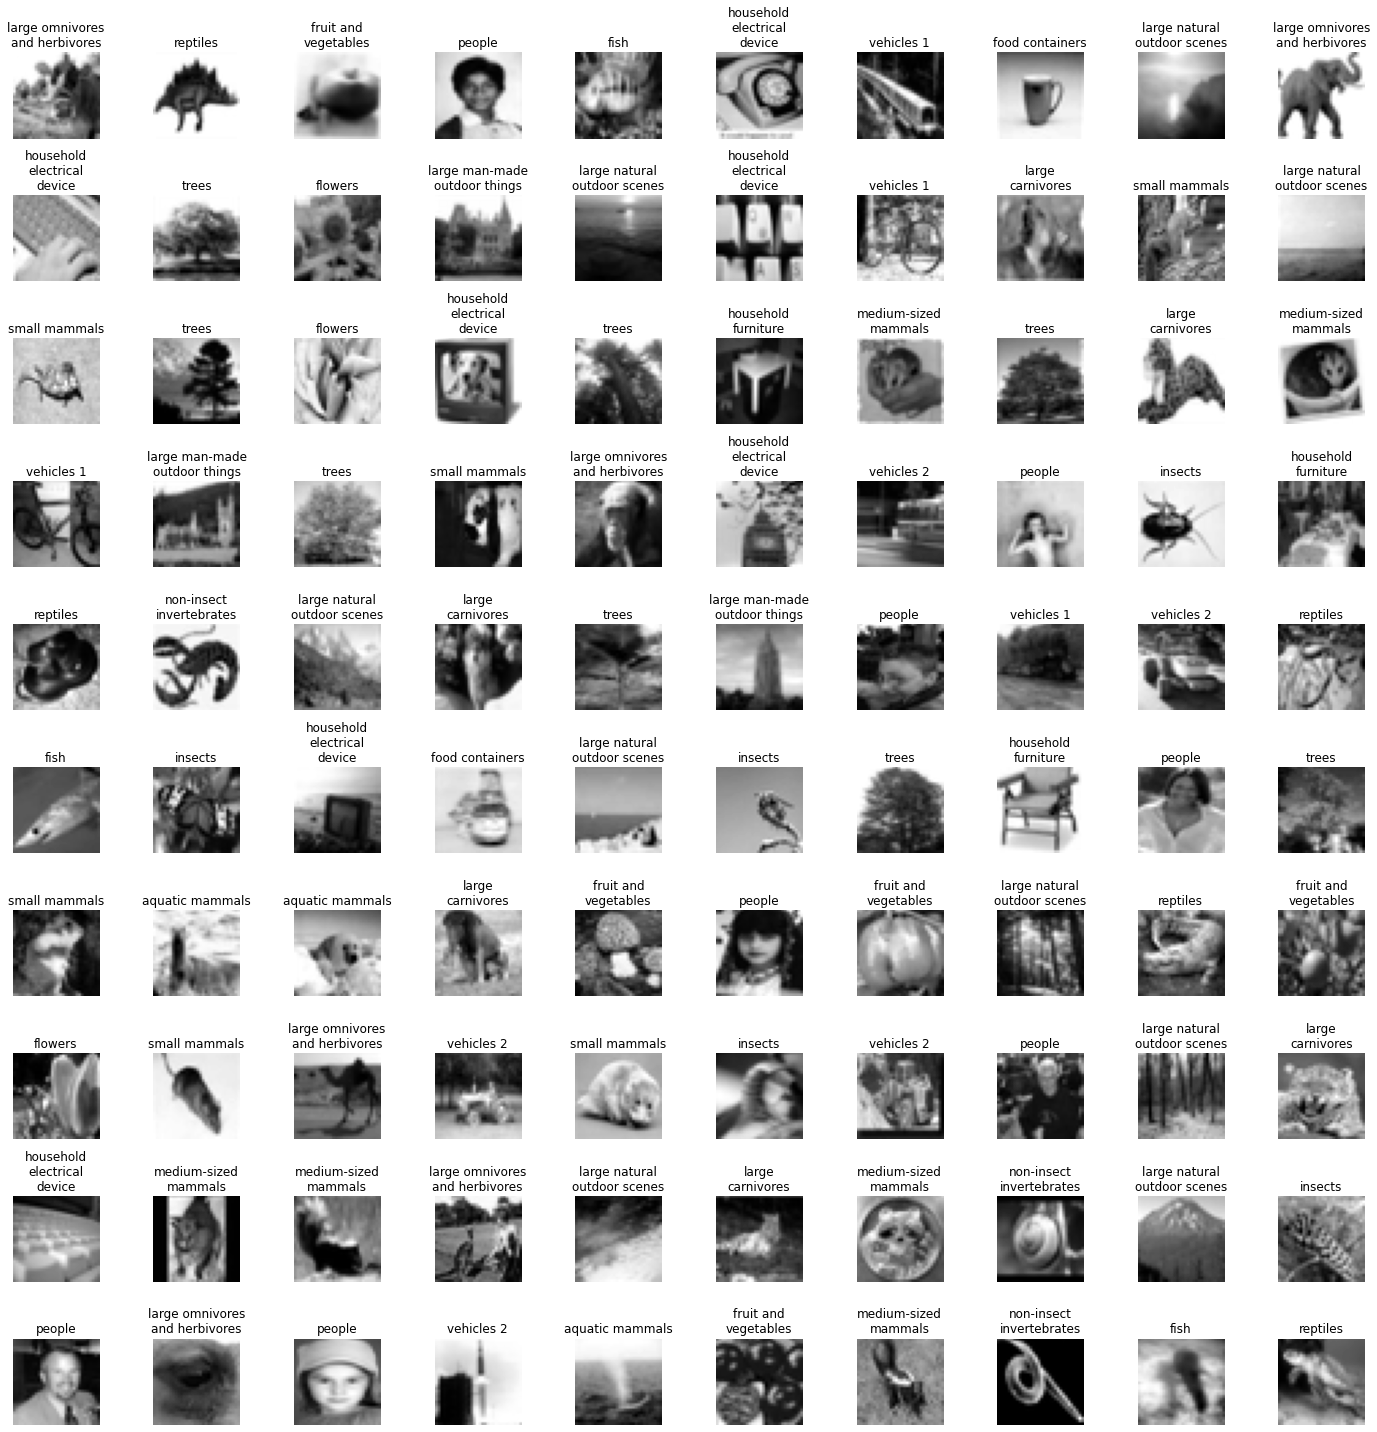

In [ ]:
# EDA to show sample gray scale images of every fine category

plt.figure(figsize = (20,20))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.title(get_named_coarse_label(coarse_Y_train[i]))
  plt.tight_layout()
  plt.imshow(X_train_gray_cv2_np[i],cmap='gray')

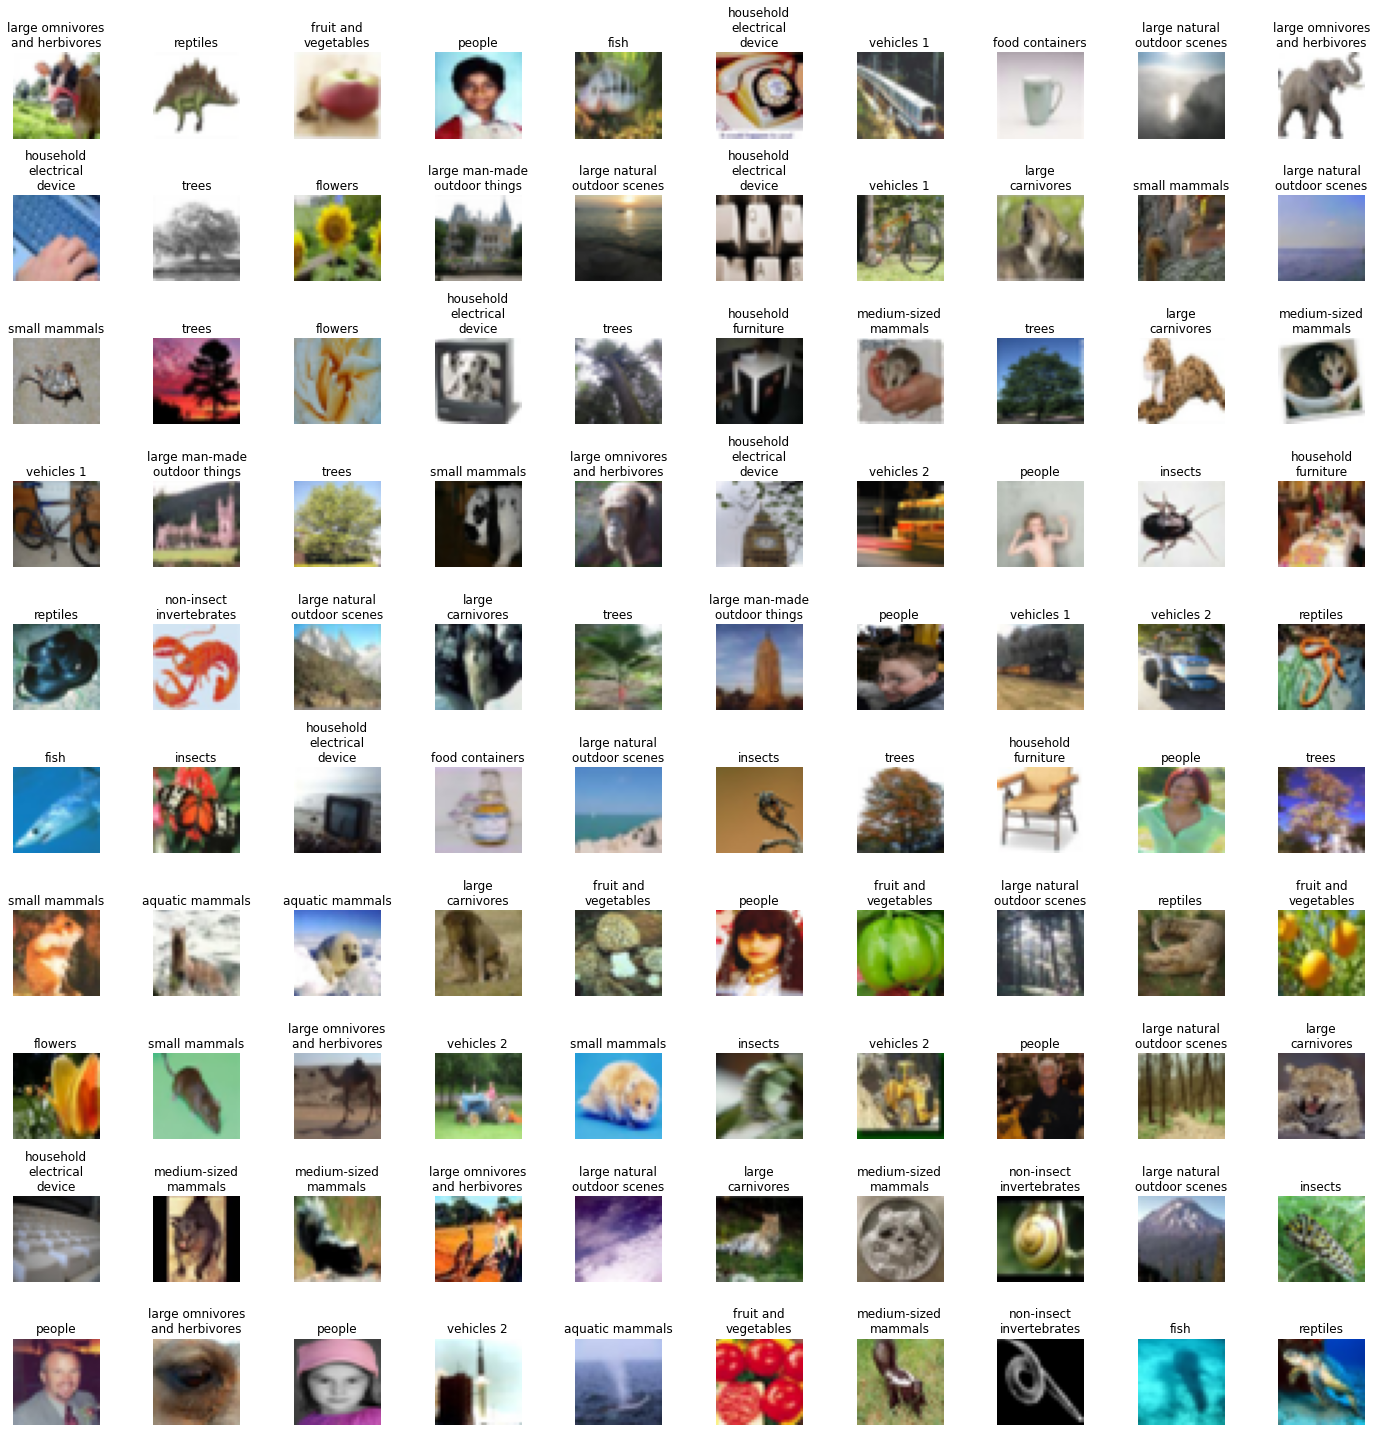

In [ ]:
# EDA to show sample color images of every fine category

plt.figure(figsize = (20,20))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.title(fine_to_named_coarse_label(Y_train[i][0]))
  plt.tight_layout()
  plt.imshow(X_train[i])


# Select Images for Feature Extraction

The following categories were selected as they contain areas of interest such as corners, edges and blobs that are distinguishable.

One image from each category

    11 large omnivores and herbivores
    5 household electrical device
    9 large man-made outdoor things  
    6 household furniture  
    18 vehicles 1  

11 large omnivores and herbivores
5 household electrical device
9 large man-made outdoor things
6 household furniture
18 vehicles 1


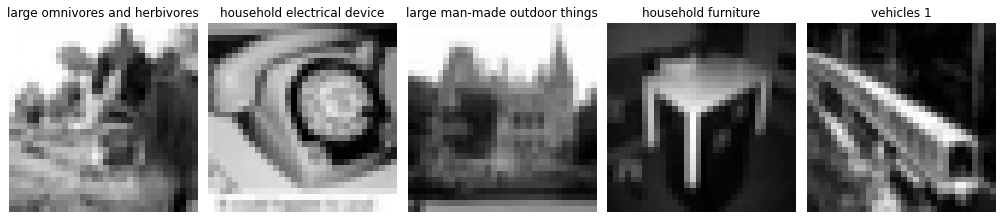

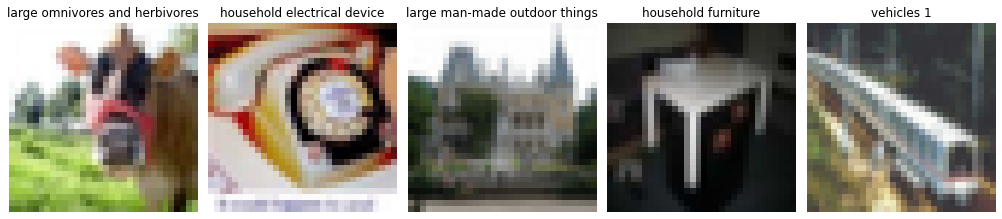

In [ ]:
# Select One Image from the following categories to demonstrate feature extraction.
# Visualize the selected images in gray scale and color

coarse_label_id_list =[11,5,9,6,18]
image_list =[]

for id in coarse_label_id_list:
  label=get_named_coarse_label_no_wrapper(id)  
  print(id, label)
  images_gray = X_train_gray_cv2_np[coarse_Y_train==id]
  images_color = X_train[coarse_Y_train==id]
  image_list.append((label,images_gray[0],images_color[0]))

plt.figure(figsize = (14,14))
for i in range(5):
  plt.subplot(1,5,1+i)
  plt.axis('off')
  plt.title(image_list[i][0])
  plt.tight_layout()
  plt.imshow(image_list[i][1],cmap='gray')

plt.figure(figsize = (14,14))
for i in range(5):
  plt.subplot(1,5,1+i)
  plt.axis('off')
  plt.title(image_list[i][0])
  plt.tight_layout()
  plt.imshow(image_list[i][2])

In [ ]:
# Define a wrapper function to display long labels

wrapper = textwrap.TextWrapper(width=15, break_long_words=True)

def fine_to_named_coarse_label(fine_label_id):
  label = wrapper.wrap(coarse_label[fine_id_coarse_id[fine_label_id]])
  return '\n'.join(label)

def get_named_coarse_label(coarse_label_id):
  label = wrapper.wrap(coarse_label[coarse_label_id])
  return '\n'.join(label)

def get_named_coarse_label_no_wrapper(coarse_label_id):
  label = (coarse_label[coarse_label_id])
  return label

# Histogram of Gradients (HOG)

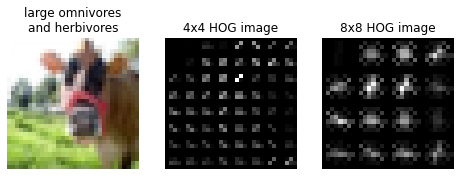

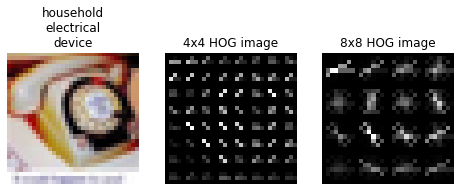

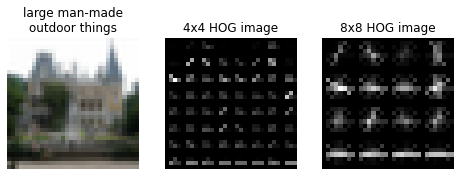

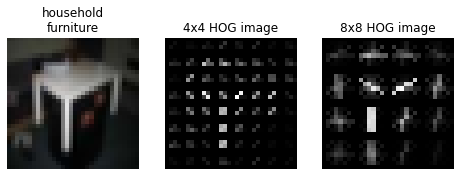

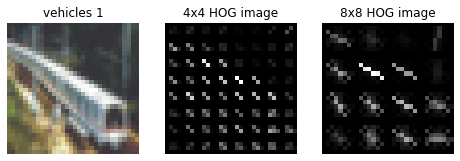

In [ ]:
# HOG display for 5 Coarse Categories

for i in range(5):
  image = image_list[i][2]
  title = image_list[i][0]
  title = wrapper.wrap(title)
  label= '\n'.join(title)

  fd_4x4, hog_img_4x4 = hog(image, orientations=9, pixels_per_cell=(4, 4),
                      cells_per_block=(2, 2), visualize=True, channel_axis = -1)
  fd_8x8, hog_img_8x8 = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis = -1)

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 8), sharex=True, sharey=True)

  ax1.axis('off')
  ax1.imshow(image, cmap=plt.cm.gray)
  ax1.set_title(label)

      
  ax2.axis('off')
  ax2.imshow(hog_img_4x4, cmap=plt.cm.gray)
  ax2.set_title(f'4x4 HOG image')

  ax3.axis('off')
  ax3.imshow(hog_img_8x8, cmap=plt.cm.gray)
  ax3.set_title(f'8x8 HOG image')
  plt.show()


# SIFT Features

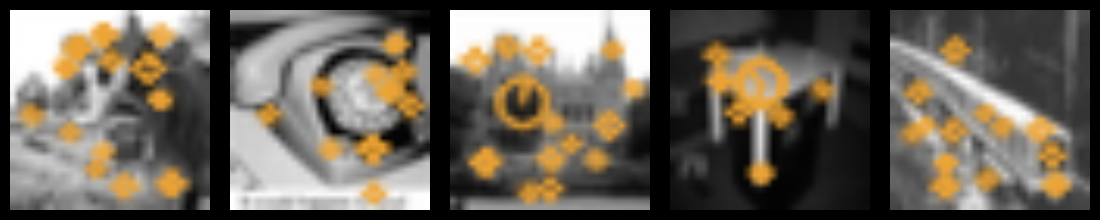

-1

In [ ]:
# SIFT Features for 5 Coarse Categories

from google.colab.patches import cv2_imshow

size = 200

# Image 1
img = image_list[0][1]
title = image_list[0][0]

sift = cv2.SIFT_create(nfeatures=20)
kp = sift.detect(img,None)
kp, des = sift.compute(img, kp)

cv2.drawKeypoints(img, kp, img_sift, (51, 163, 236),
                  cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

resized_img_sift = cv2.resize(img_sift, (size,size))
black = [0,0,0]     #---Color of the border---
img1_border = cv2.copyMakeBorder(resized_img_sift,10,10,10,10,cv2.BORDER_CONSTANT,value=black )

# Image 2
img = image_list[1][1]
title = image_list[1][0]

sift = cv2.SIFT_create(nfeatures=20)
kp = sift.detect(img,None)
kp, des = sift.compute(img, kp)

cv2.drawKeypoints(img, kp, img_sift, (51, 163, 236),
                  cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

resized_img_sift = cv2.resize(img_sift, (size,size))
black = [0,0,0]     #---Color of the border---
img2_border = cv2.copyMakeBorder(resized_img_sift,10,10,10,10,cv2.BORDER_CONSTANT,value=black )

# Image 3
img = image_list[2][1]
title = image_list[2][0]

sift = cv2.SIFT_create(nfeatures=20)
kp = sift.detect(img,None)
kp, des = sift.compute(img, kp)

cv2.drawKeypoints(img, kp, img_sift, (51, 163, 236),
                  cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

resized_img_sift = cv2.resize(img_sift, (size,size))
black = [0,0,0]     #---Color of the border---
img3_border = cv2.copyMakeBorder(resized_img_sift,10,10,10,10,cv2.BORDER_CONSTANT,value=black )

# Image 4
img = image_list[3][1]
title = image_list[3][0]

sift = cv2.SIFT_create(nfeatures=20)
kp = sift.detect(img,None)
kp, des = sift.compute(img, kp)

cv2.drawKeypoints(img, kp, img_sift, (51, 163, 236),
                  cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# img_sift =cv2.drawKeypoints(img, kp, img, (51, 163, 236),
#                   cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

resized_img_sift = cv2.resize(img_sift, (size,size))
black = [0,0,0]     #---Color of the border---
img4_border = cv2.copyMakeBorder(resized_img_sift,10,10,10,10,cv2.BORDER_CONSTANT,value=black )

# image 5
img = image_list[4][1]
title = image_list[4][0]

sift = cv2.SIFT_create(nfeatures=20)
kp = sift.detect(img,None)
kp, des = sift.compute(img, kp)

cv2.drawKeypoints(img, kp, img_sift, (51, 163, 236),
                  cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

resized_img_sift = cv2.resize(img_sift, (size,size))
black = [0,0,0]     #---Color of the border---
img5_border = cv2.copyMakeBorder(resized_img_sift,10,10,10,10,cv2.BORDER_CONSTANT,value=black )

hcat = cv2.hconcat((img1_border,img2_border,img3_border,img4_border,img5_border))
cv2_imshow(hcat)

cv2.waitKey(0)


# Gray level co-occurrence matrices (GLCM) Features

In [ ]:
# import libraries from skimage

import matplotlib.pyplot as plt
import skimage

from skimage.feature import graycomatrix, graycoprops
from skimage import io
import cv2
import numpy as np

PATCH_SIZE = 6

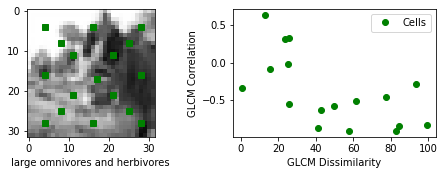

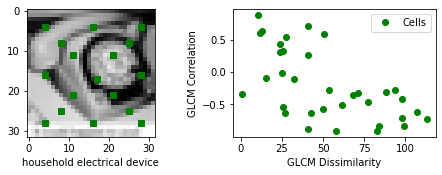

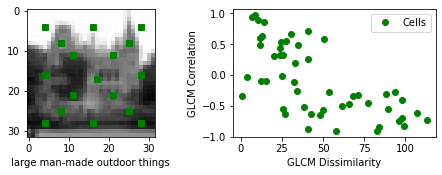

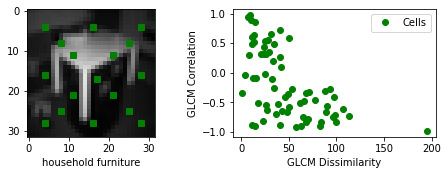

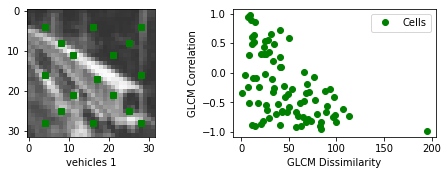

In [ ]:
# Define Patch Location to Generate GLCM Features

cell_locations = [(1,1),(25,25),(1,25),(13,25),(25,13),(25,1),(1,13),(13,1),(5,5),(22,5),(5,22),(22,22),(14,14),(8,8),(18,18),(18,8),(8,18)]
cell_patches = []

for item in image_list:
  img = item[1]
  img_color = item[2]
  title = item[0]
  # img = image_list[1][1]
  for loc in cell_locations:
    cell_patches.append(img[loc[0]:loc[0] + PATCH_SIZE, loc[1]:loc[1] + PATCH_SIZE])

# compute GLCM Properties for Each Patch
  diss_sim = []
  corr = []
  homogen = []
  energy = []
  contrast = []
  for patch in (cell_patches):
      glcm = graycomatrix(patch, distances=[5], angles=[0], levels=256,
                          symmetric=True, normed=True)
      diss_sim.append(graycoprops(glcm, 'dissimilarity')[0, 0]) #[0,0] to convert array to value
      corr.append(graycoprops(glcm, 'correlation')[0, 0])
      homogen.append(graycoprops(glcm, 'homogeneity')[0, 0])
      energy.append(graycoprops(glcm, 'energy')[0, 0])
      contrast.append(graycoprops(glcm, 'contrast')[0, 0])

  # create the figure
  fig = plt.figure(figsize=(8, 8))

  # display original image with locations of patches
  ax = fig.add_subplot(3, 2, 1)
  ax.imshow(img, cmap=plt.cm.gray,
            vmin=0, vmax=255)
  for (y, x) in cell_locations:
      ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
  ax.set_xlabel(title)
  # ax.set_xticks([])
  # ax.set_yticks([])
  ax.axis('image')

  # for each patch, plot (dissimilarity, correlation)
  ax = fig.add_subplot(3, 2, 2)
  ax.plot(diss_sim[:len(cell_patches)], corr[:len(cell_patches)], 'go',
          label='Cells')
  ax.set_xlabel('GLCM Dissimilarity')
  ax.set_ylabel('GLCM Correlation')
  ax.legend()

# Harris Corner Detector

In [ ]:
def display_harris_corners_new(image_list):

  fig, ax = plt.subplots(1, 5, figsize=(15,15))
  fig.tight_layout()

  # First Image
  img_gray = image_list[0][1]
  img_color = image_list[0][2]
  title = image_list[0][0]
  img_float = img_gray.astype(np.float32) / 255.0 
  dst = cv2.cornerHarris(img_float, 2, 23, 0.04)  
  img_color[dst > 0.01 * dst.max()] = [255, 0, 0]

  ax[0].imshow(img_color) 
  ax[0].set_title(f"{title}", fontsize="9")
  ax[0].axis('off')

  # First Image
  img_gray = image_list[0][1]
  img_color = image_list[0][2]
  title = image_list[0][0]
  img_float = img_gray.astype(np.float32) / 255.0 
  dst = cv2.cornerHarris(img_float, 2, 23, 0.04)  
  img_color[dst > 0.01 * dst.max()] = [255, 0, 0]

  ax[0].imshow(img_color) 
  ax[0].set_title(f"{title}", fontsize="9")
  ax[0].axis('off')

  # Second Image
  img_gray = image_list[1][1]
  img_color = image_list[1][2]
  title = image_list[1][0]
  img_float = img_gray.astype(np.float32) / 255.0 
  dst = cv2.cornerHarris(img_float, 2, 23, 0.04)  
  img_color[dst > 0.01 * dst.max()] = [255, 0, 0]

  ax[1].imshow(img_color) 
  ax[1].set_title(f"{title}", fontsize="9")
  ax[1].axis('off')

  # Third Image
  img_gray = image_list[2][1]
  img_color = image_list[2][2]
  title = image_list[2][0]
  img_float = img_gray.astype(np.float32) / 255.0 
  dst = cv2.cornerHarris(img_float, 2, 23, 0.04)  
  img_color[dst > 0.01 * dst.max()] = [255, 0, 0]

  ax[2].imshow(img_color) 
  ax[2].set_title(f"{title}", fontsize="9")
  ax[2].axis('off')

  # Fourth Image
  img_gray = image_list[3][1]
  img_color = image_list[3][2]
  title = image_list[3][0]
  img_float = img_gray.astype(np.float32) / 255.0 
  dst = cv2.cornerHarris(img_float, 2, 23, 0.04)  
  img_color[dst > 0.01 * dst.max()] = [255, 0, 0]

  ax[3].imshow(img_color) 
  ax[3].set_title(f"{title}", fontsize="9")
  ax[3].axis('off')

  # Fifth Image
  img_gray = image_list[4][1]
  img_color = image_list[4][2]
  title = image_list[4][0]
  img_float = img_gray.astype(np.float32) / 255.0 
  dst = cv2.cornerHarris(img_float, 2, 23, 0.04)  
  img_color[dst > 0.01 * dst.max()] = [255, 0, 0]

  ax[4].imshow(img_color) 
  ax[4].set_title(f"{title}", fontsize="9")
  ax[4].axis('off')

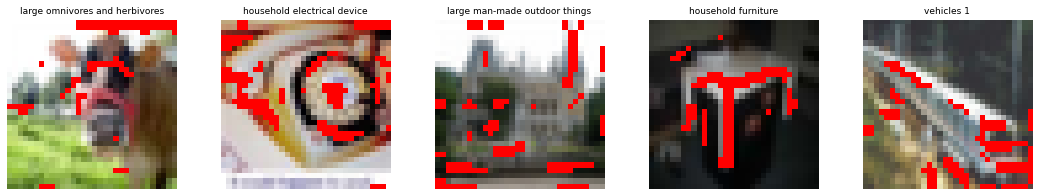

In [ ]:
display_harris_corners_new(image_list)